In [ ]:
%matplotlib widget
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))

import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.widgets import Slider
from IPython.display import HTML
from DGM import DGMNet
from tqdm.notebook import tqdm

class Experiment:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.name = os.path.basename(folder_path)

        # Load metadata
        self.metadata = self._load_json("metadata.json")
        self.model_parameters = self.metadata.get("model_parameters", {})
        self.network_parameters = self.metadata.get("network_parameters", {})
        self.training_parameters = self.metadata.get("training_parameters", {})
        self.domain_bounds = self.metadata.get("domain_bounds", {})
        self.experiment_name = self.metadata.get("experiment_name", self.name)

        try:
            self.history = self._load_csv("training_history.csv")
        except:
            self.history = None
            print(f"Missing training history file for {self.experiment_name}")

        self.dtype = self.metadata["training_parameters"].get("dtype", "float32")
        self.dtype = tf.float64 if self.dtype == "float64" else tf.float32

        # Extract model parameters (4D CIR model)
        self.mu = tf.constant(self.model_parameters["mu"], dtype=self.dtype)
        self.sigma = tf.constant(self.model_parameters["sigma"], dtype=self.dtype)
        self.a = tf.constant(self.model_parameters["a"], dtype=self.dtype)
        self.b = tf.constant(self.model_parameters["b"], dtype=self.dtype)
        self.r = tf.constant(self.model_parameters["r"], dtype=self.dtype)
        self.T = tf.constant(self.model_parameters["T"], dtype=self.dtype)
        self.L = tf.constant(self.model_parameters.get("L", 0.5), dtype=self.dtype)

        # CIR parameters
        self.kappa = tf.constant(self.model_parameters.get("kappa", 2.0), dtype=self.dtype)
        self.beta = tf.constant(self.model_parameters.get("beta", 1.5), dtype=self.dtype)
        self.delta = tf.constant(self.model_parameters.get("delta", 0.3), dtype=self.dtype)
        self.rho = tf.constant(self.model_parameters.get("rho", -0.5), dtype=self.dtype)

        self.V_scale = tf.constant(self.metadata.get("V_scale", 1.0), dtype=self.dtype)
        self.alpha_scale = tf.constant(self.metadata.get("alpha_scale", 1.0), dtype=self.dtype)

        self.pi_expr = self.model_parameters.get("pi", "P")
        self.pi = self._build_pi_function(self.pi_expr)

        # Setup normalization for 4D (t, P, Y, C)
        self._setup_normalization()

        # Load models
        self.f_theta = self._build_and_load_model("f_theta.keras")
        self.g_phi = self._build_and_load_model("g_phi.keras")

    def _setup_normalization(self):
        """Setup normalization parameters for 4D case (t, P, Y, C)"""
        bounds_keys = list(self.domain_bounds.keys())
        t_bounds, P_bounds, Y_bounds, C_bounds = [self.domain_bounds[key] for key in bounds_keys]
        
        self.t_min, self.t_max = t_bounds
        self.P_min, self.P_max = P_bounds
        self.Y_min, self.Y_max = Y_bounds
        self.C_min, self.C_max = C_bounds

        self.t_mean = tf.constant((self.t_max + self.t_min) / 2, dtype=self.dtype)
        self.t_scale = tf.constant((self.t_max - self.t_min) / 2, dtype=self.dtype)
        self.P_mean = tf.constant((self.P_max + self.P_min) / 2, dtype=self.dtype)
        self.P_scale = tf.constant((self.P_max - self.P_min) / 2, dtype=self.dtype)
        self.Y_mean = tf.constant((self.Y_max + self.Y_min) / 2, dtype=self.dtype)
        self.Y_scale = tf.constant((self.Y_max - self.Y_min) / 2, dtype=self.dtype)
        self.C_mean = tf.constant((self.C_max + self.C_min) / 2, dtype=self.dtype)
        self.C_scale = tf.constant((self.C_max - self.C_min) / 2, dtype=self.dtype)

        self.normalize_inputs = lambda t, P, Y, C: (
            (t - self.t_mean) / self.t_scale,
            (P - self.P_mean) / self.P_scale,
            (Y - self.Y_mean) / self.Y_scale,
            (C - self.C_mean) / self.C_scale,
        )
    
    def plot_history(self):
        if self.history is None:
            print("No training history loaded.")
            return
    
        # --- Plot value network losses ---
        plt.figure(figsize=(10, 5))
        plt.plot(self.history["total_loss"], label="Total Loss")
        plt.plot(self.history["pde_loss"], label="PDE Loss")
        plt.plot(self.history["terminal_loss"], label="Terminal Loss")
        plt.yscale("log")
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.title(f"Loss History - {self.experiment_name} (4D CIR)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
        # --- Plot control network loss ---
        plt.figure(figsize=(8, 4))
        plt.plot(self.history["control_loss"], label="Control Loss")
        plt.yscale("log")
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.title(f"Control Loss History - {self.experiment_name} (4D CIR)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def _build_pi_function(self, expr):
        def pi(P):
            local_dict = {
                'P': P,
                'sqrt': tf.sqrt,
                'log': tf.math.log,
                'exp': tf.exp,
                'abs': tf.abs,
                'pow': tf.pow,
                'min': tf.minimum,
                'max': tf.maximum,
                'tf': tf,
            }
            return eval(expr, {"__builtins__": {}}, local_dict)
        return pi

    def _build_and_load_model(self, filename, final_trans=None, dtype=None):
        path = os.path.join(self.folder_path, filename)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing model file: {filename}")

        net = DGMNet(
            layer_width=self.network_parameters["layer_width"],
            n_layers=self.network_parameters["n_layers"],
            input_dim=self.network_parameters["input_dim"],
            dtype=self.dtype if dtype is None else dtype,
            final_trans=final_trans
        )
        dummy_input = tf.zeros((1, self.network_parameters["input_dim"]), dtype=self.dtype)
        dummy_t = tf.zeros((1, 1), dtype=self.dtype)
        net(dummy_t, dummy_input)
        net.load_weights(path)
        return net

    def _load_json(self, filename):
        with open(os.path.join(self.folder_path, filename), 'r') as f:
            return json.load(f)

    def _load_csv(self, filename):
        return pd.read_csv(os.path.join(self.folder_path, filename))

    def __repr__(self):
        return f"<Experiment '{self.experiment_name}' (4D CIR) σ={self.sigma}>"

    def animate_primal_hjb_slice(self, P_points=60, Y_points=60, slider_dim='C', slider_values=None):
        """
        Interactive 4D visualization with sliders.
        - slider_dim: 'P', 'Y', or 'C' - which dimension to use as slider
        - The plot will show the other two dimensions as axes
        - Two sliders: one for time, one for the slider dimension
        """
        return self._animate_4d_interactive(P_points, Y_points, slider_dim, slider_values)

    def _animate_4d_interactive(self, dim1_points=50, dim2_points=50, slider_dim='C', slider_values=None):
        """Interactive 4D visualization with sliders"""
        tf.config.run_functions_eagerly(True)
        
        # Determine which dimensions to plot and which to use as slider
        dims = {'P': (self.P_min, self.P_max), 'Y': (self.Y_min, self.Y_max), 'C': (self.C_min, self.C_max)}
        plot_dims = [d for d in dims.keys() if d != slider_dim]
        
        # Create grids for the two plot dimensions
        dim1, dim2 = plot_dims
        vals1 = np.linspace(dims[dim1][0], dims[dim1][1], dim1_points)
        vals2 = np.linspace(dims[dim2][0], dims[dim2][1], dim2_points)
        grid1, grid2 = np.meshgrid(vals1, vals2)
        
        # Setup slider values
        if slider_values is None:
            slider_values = np.linspace(dims[slider_dim][0], dims[slider_dim][1], 20)
        
        # Create figure with sliders
        fig = plt.figure(figsize=(16, 12))
        
        # Create 3D subplots
        axes = []
        for i in range(4):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')
            axes.append(ax)
        
        # Add slider axes at the bottom
        plt.subplots_adjust(bottom=0.15)
        ax_time = plt.axes([0.1, 0.05, 0.35, 0.03])
        ax_slider_dim = plt.axes([0.55, 0.05, 0.35, 0.03])
        
        # Create sliders
        slider_time = Slider(ax_time, 'Time', 0, self.T, valinit=0.5*self.T, valfmt='%.2f')
        slider_other = Slider(ax_slider_dim, slider_dim, dims[slider_dim][0], dims[slider_dim][1], 
                             valinit=0.5*(dims[slider_dim][0] + dims[slider_dim][1]), valfmt='%.2f')
        
        titles = ['Value Function V', 'HJB Residual', 'Control α', 'Second derivative V_PP']
        
        def compute_quantities_4d(t_val, slider_val):
            """Compute all quantities for 4D case"""
            flat_grid1 = grid1.reshape(-1, 1)
            flat_grid2 = grid2.reshape(-1, 1)
            n_points = len(flat_grid1)
            
            # Build coordinate arrays
            coords = {}
            coords[dim1] = tf.constant(flat_grid1, dtype=self.dtype)
            coords[dim2] = tf.constant(flat_grid2, dtype=self.dtype)
            coords[slider_dim] = tf.constant(slider_val * np.ones((n_points, 1)), dtype=self.dtype)
            
            t = tf.constant(t_val * np.ones((n_points, 1)), dtype=self.dtype)
            P, Y, C = coords['P'], coords['Y'], coords['C']

            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch([t, P, Y, C])
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch([t, P, Y, C])
                    t_norm, P_norm, Y_norm, C_norm = self.normalize_inputs(t, P, Y, C)
                    V_tilde = self.f_theta(t_norm, tf.concat([P_norm, Y_norm, C_norm], axis=1))
                    alpha_tilde = self.g_phi(t_norm, tf.concat([P_norm, Y_norm, C_norm], axis=1))

                V_tilde_t = tape1.gradient(V_tilde, t)
                V_tilde_P = tape1.gradient(V_tilde, P)
                V_tilde_Y = tape1.gradient(V_tilde, Y)
                V_tilde_C = tape1.gradient(V_tilde, C)
                del tape1
            V_tilde_PP = tape2.gradient(V_tilde_P, P)
            V_tilde_CC = tape2.gradient(V_tilde_C, C)
            V_tilde_PC = tape2.gradient(V_tilde_P, C)
            del tape2

            # Safe derivatives
            eps = tf.constant(1e-6, dtype=self.dtype)
            
            def make_safe(deriv):
                sign = tf.sign(deriv)
                sign = tf.where(sign == 0, tf.ones_like(sign), sign)
                return tf.where(tf.abs(deriv) < eps, eps * sign, deriv)
            
            V_tilde_PP_safe = make_safe(V_tilde_PP)
            V_tilde_CC_safe = make_safe(V_tilde_CC)

            # 4D HJB residual computation with CIR terms
            alpha_orig = self.alpha_scale * alpha_tilde
            
            # P dynamics terms
            drift_P = self.mu * alpha_orig * P * V_tilde_P
            diffusion_P = (self.sigma**2 * alpha_orig**2 * P**2 * V_tilde_PP_safe) / 2
            
            # Mixed term from correlation
            sqrt_C_safe = tf.sqrt(tf.maximum(C, tf.constant(1e-8, dtype=self.dtype)))
            mixed_PC = self.rho * self.sigma * self.delta * alpha_orig * P * sqrt_C_safe * V_tilde_PC
            
            # Y dynamics 
            advec_Y = C * (self.a + self.b * P) * V_tilde_Y
            
            # CIR dynamics for C
            drift_C = self.kappa * (self.beta - C) * V_tilde_C
            diffusion_C = (self.delta**2 * C * V_tilde_CC_safe) / 2
            
            # Source term
            source_term = self.pi(P) / self.V_scale

            V_tilde = tf.cast(V_tilde, self.dtype)
            residual = self.V_scale * (V_tilde_t + drift_P + diffusion_P + mixed_PC + 
                                      advec_Y + drift_C + diffusion_C + source_term - self.r * V_tilde)

            # Scaled quantities for display
            V = self.V_scale * V_tilde
            alpha = self.alpha_scale * alpha_tilde
            V_PP_safe = self.V_scale * V_tilde_PP_safe

            return (
                tf.reshape(V, grid1.shape).numpy(),
                tf.reshape(residual, grid1.shape).numpy(),
                tf.reshape(alpha, grid1.shape).numpy(),
                tf.reshape(V_PP_safe, grid1.shape).numpy()
            )

        def update_plot():
            t_val = slider_time.val
            slider_val = slider_other.val
            
            V_vals, R_vals, A_vals, V_PP_vals = compute_quantities_4d(t_val, slider_val)
            
            # Clear and redraw all surfaces
            for ax in axes:
                ax.clear()
            
            for i, (data, title, ax) in enumerate(zip([V_vals, R_vals, A_vals, V_PP_vals], titles, axes)):
                data = np.nan_to_num(data, nan=0.0, posinf=1e6, neginf=-1e6)
                surf = ax.plot_surface(grid1, grid2, data, cmap='viridis', alpha=0.8)
                
                ax.set_xlabel(dim1)
                ax.set_ylabel(dim2)
                ax.set_zlabel(title)
                ax.set_title(f"{title} (t={t_val:.2f}, {slider_dim}={slider_val:.2f})")
            
            plt.draw()

        # Connect sliders to update function
        slider_time.on_changed(lambda val: update_plot())
        slider_other.on_changed(lambda val: update_plot())
        
        # Initial plot
        update_plot()
        
        plt.show()
        return fig, (slider_time, slider_other)

    def plot_static_slice(self, t_val=None, C_val=None, P_points=100, Y_points=100, slider_dim='C'):
        """
        Create a static 2D slice plot for 4D case.
        Shows a P-Y slice (or other two dimensions) at given time and slider dimension value.
        """
        if t_val is None:
            t_val = 0.5 * self.T
        
        # Determine which dimensions to plot and which to use as fixed value
        dims = {'P': (self.P_min, self.P_max), 'Y': (self.Y_min, self.Y_max), 'C': (self.C_min, self.C_max)}
        plot_dims = [d for d in dims.keys() if d != slider_dim]
        
        # Set default value for slider dimension
        if slider_dim == 'C' and C_val is None:
            slider_val = 0.5 * (self.C_min + self.C_max)
        elif slider_dim == 'P' and C_val is None:  # reuse C_val parameter for any slider dimension
            slider_val = 0.5 * (self.P_min + self.P_max)
        elif slider_dim == 'Y' and C_val is None:
            slider_val = 0.5 * (self.Y_min + self.Y_max)
        else:
            slider_val = C_val
        
        # Create grids for the two plot dimensions
        dim1, dim2 = plot_dims
        vals1 = np.linspace(dims[dim1][0], dims[dim1][1], P_points)
        vals2 = np.linspace(dims[dim2][0], dims[dim2][1], Y_points)
        grid1, grid2 = np.meshgrid(vals1, vals2)
        
        flat_grid1 = grid1.reshape(-1, 1)
        flat_grid2 = grid2.reshape(-1, 1)
        n_points = len(flat_grid1)
        
        # Build coordinate arrays
        coords = {}
        coords[dim1] = tf.constant(flat_grid1, dtype=self.dtype)
        coords[dim2] = tf.constant(flat_grid2, dtype=self.dtype)
        coords[slider_dim] = tf.constant(slider_val * np.ones((n_points, 1)), dtype=self.dtype)
        
        t = tf.constant(t_val * np.ones((n_points, 1)), dtype=self.dtype)
        P, Y, C = coords['P'], coords['Y'], coords['C']

        # Compute quantities using 4D logic
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([t, P, Y, C])
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch([t, P, Y, C])
                t_norm, P_norm, Y_norm, C_norm = self.normalize_inputs(t, P, Y, C)
                V_tilde = self.f_theta(t_norm, tf.concat([P_norm, Y_norm, C_norm], axis=1))
                alpha_tilde = self.g_phi(t_norm, tf.concat([P_norm, Y_norm, C_norm], axis=1))

            V_tilde_t = tape1.gradient(V_tilde, t)
            V_tilde_P = tape1.gradient(V_tilde, P)
            V_tilde_Y = tape1.gradient(V_tilde, Y)
            V_tilde_C = tape1.gradient(V_tilde, C)
            del tape1
        V_tilde_PP = tape2.gradient(V_tilde_P, P)
        V_tilde_CC = tape2.gradient(V_tilde_C, C)
        V_tilde_PC = tape2.gradient(V_tilde_P, C)
        del tape2

        # Safe derivatives and HJB computation (same as in interactive version)
        eps = tf.constant(1e-6, dtype=self.dtype)
        
        def make_safe(deriv):
            sign = tf.sign(deriv)
            sign = tf.where(sign == 0, tf.ones_like(sign), sign)
            return tf.where(tf.abs(deriv) < eps, eps * sign, deriv)
        
        V_tilde_PP_safe = make_safe(V_tilde_PP)
        alpha_orig = self.alpha_scale * alpha_tilde
        
        # 4D HJB residual computation
        drift_P = self.mu * alpha_orig * P * V_tilde_P
        diffusion_P = (self.sigma**2 * alpha_orig**2 * P**2 * V_tilde_PP_safe) / 2
        sqrt_C_safe = tf.sqrt(tf.maximum(C, tf.constant(1e-8, dtype=self.dtype)))
        mixed_PC = self.rho * self.sigma * self.delta * alpha_orig * P * sqrt_C_safe * V_tilde_PC
        advec_Y = C * (self.a + self.b * P) * V_tilde_Y
        drift_C = self.kappa * (self.beta - C) * V_tilde_C
        diffusion_C = (self.delta**2 * C * make_safe(V_tilde_CC)) / 2
        source_term = self.pi(P) / self.V_scale

        V_tilde = tf.cast(V_tilde, self.dtype)
        residual = self.V_scale * (V_tilde_t + drift_P + diffusion_P + mixed_PC + 
                                  advec_Y + drift_C + diffusion_C + source_term - self.r * V_tilde)

        # Convert to numpy arrays for plotting
        V_vals = (self.V_scale * V_tilde).numpy().reshape(grid1.shape)
        R_vals = residual.numpy().reshape(grid1.shape)
        A_vals = (self.alpha_scale * alpha_tilde).numpy().reshape(grid1.shape)
        V_PP_vals = (self.V_scale * V_tilde_PP_safe).numpy().reshape(grid1.shape)
        
        title_suffix = f"t={t_val:.2f}, {slider_dim}={slider_val:.2f}"
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        titles = ['Value Function V', 'HJB Residual', 'Control α', 'Second derivative V_PP']
        data_arrays = [V_vals, R_vals, A_vals, V_PP_vals]
        
        for i, (ax, title, data) in enumerate(zip(axes, titles, data_arrays)):
            data = np.nan_to_num(data, nan=0.0, posinf=1e6, neginf=-1e6)
            im = ax.contourf(grid1, grid2, data, levels=20, cmap='viridis')
            ax.set_xlabel(dim1)
            ax.set_ylabel(dim2) 
            ax.set_title(f"{title} ({title_suffix})")
            plt.colorbar(im, ax=ax)
        
        plt.tight_layout()
        plt.show()


    def plot_sample_trajectories(self, T_steps=200, N_paths=6, seed=None, P0=0.6, Y0=0.0, C0=1.5):
        """
        Simulate and plot sample trajectories of P_t, Y_t, C_t, and alpha_t under the learned control,
        and compare with P_t under a fixed 'alpha = 1' baseline.
        Also prints V(0,P0,Y0,C0) and the pathwise discounted reward for each trajectory.

        Fixes:
        - scales alpha by self.alpha_scale
        - scales V0 by self.V_scale
        - uses self.pi(P) for the running payoff
        - converts TF scalars to floats before NumPy ops
        """
        tf.config.run_functions_eagerly(True)

        # Convert TF scalars to Python floats for NumPy operations
        T = float(self.T.numpy())
        r = float(self.r.numpy())
        rho = float(self.rho.numpy())
        mu = float(self.mu.numpy())
        sigma = float(self.sigma.numpy())
        kappa = float(self.kappa.numpy())
        beta = float(self.beta.numpy())
        delta = float(self.delta.numpy())
        V_scale = float(self.V_scale.numpy())
        alpha_scale = float(self.alpha_scale.numpy())

        # Time grid
        times = np.linspace(0.0, T, T_steps + 1)
        dt = T / T_steps
        sqrt_dt = np.sqrt(dt)
        discount = np.exp(-r * times)

        rng = np.random.default_rng(seed)

        # Plot setup
        n_cols = 2
        n_rows = (N_paths + 1) // 2
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
        axes = axes.flatten()

        for path_idx in range(N_paths):
            P_control = np.zeros(T_steps + 1)
            P_uncontrolled = np.zeros(T_steps + 1)
            Y = np.zeros(T_steps + 1)
            C = np.zeros(T_steps + 1)
            alpha = np.zeros(T_steps + 1)
            pi_vals = np.zeros(T_steps + 1)

            P_control[0] = P0
            P_uncontrolled[0] = P0
            Y[0] = Y0
            C[0] = C0

            for t_idx in range(T_steps):
                t = times[t_idx]
                # Build TF inputs
                t_tensor = tf.constant([[t]], dtype=self.dtype)
                P_tensor = tf.constant([[P_control[t_idx]]], dtype=self.dtype)
                Y_tensor = tf.constant([[Y[t_idx]]], dtype=self.dtype)
                C_tensor = tf.constant([[C[t_idx]]], dtype=self.dtype)

                t_norm, P_norm, Y_norm, C_norm = self.normalize_inputs(t_tensor, P_tensor, Y_tensor, C_tensor)
                model_in = tf.concat([P_norm, Y_norm, C_norm], axis=1)

                # Control (SCALED!)
                alpha_t_tilde = self.g_phi(t_norm, model_in).numpy().flatten()[0]
                alpha_t = alpha_scale * float(alpha_t_tilde)
                alpha[t_idx] = alpha_t

                # Correlated BMs
                dW1 = rng.normal(0.0, sqrt_dt)         # for P
                dW2_indep = rng.normal(0.0, sqrt_dt)   # for C (independent)
                dW2 = rho * dW1 + np.sqrt(max(1.0 - rho**2, 0.0)) * dW2_indep  # correlate

                # Euler updates
                # Controlled P
                P_control[t_idx + 1] = P_control[t_idx] + alpha_t * P_control[t_idx] * (mu * dt + sigma * dW1)
                # Baseline P (alpha = 1)
                P_uncontrolled[t_idx + 1] = P_uncontrolled[t_idx] * (1.0 + mu * dt + sigma * dW1)

                # Y: integral of C(a + b P_control)
                Y[t_idx + 1] = Y[t_idx] + C[t_idx] * (float(self.a.numpy()) + float(self.b.numpy()) * P_control[t_idx]) * dt

                # CIR C
                C_drift = kappa * (beta - C[t_idx]) * dt
                C_diffusion = delta * np.sqrt(max(C[t_idx], 1e-8)) * dW2
                C[t_idx + 1] = max(C[t_idx] + C_drift + C_diffusion, 1e-8)

                # Running payoff using configured pi(.)
                pi_vals[t_idx] = float(self.pi(tf.constant([[P_control[t_idx]]], dtype=self.dtype)).numpy().squeeze())

            # Final alpha at T (scaled) and final pi(P_T)
            t_tensor = tf.constant([[T]], dtype=self.dtype)
            P_tensor = tf.constant([[P_control[-1]]], dtype=self.dtype)
            Y_tensor = tf.constant([[Y[-1]]], dtype=self.dtype)
            C_tensor = tf.constant([[C[-1]]], dtype=self.dtype)
            t_norm, P_norm, Y_norm, C_norm = self.normalize_inputs(t_tensor, P_tensor, Y_tensor, C_tensor)
            model_in = tf.concat([P_norm, Y_norm, C_norm], axis=1)
            alpha[-1] = alpha_scale * float(self.g_phi(t_norm, model_in).numpy().flatten()[0])
            pi_vals[-1] = float(self.pi(tf.constant([[P_control[-1]]], dtype=self.dtype)).numpy().squeeze())

            # Value at t=0 (SCALED!)
            t0 = tf.constant([[0.0]], dtype=self.dtype)
            P0_tf = tf.constant([[P0]], dtype=self.dtype)
            Y0_tf = tf.constant([[Y0]], dtype=self.dtype)
            C0_tf = tf.constant([[C0]], dtype=self.dtype)
            t0_norm, P0_norm, Y0_norm, C0_norm = self.normalize_inputs(t0, P0_tf, Y0_tf, C0_tf)
            input0 = tf.concat([P0_norm, Y0_norm, C0_norm], axis=1)
            V0_tilde = float(self.f_theta(t0_norm, input0).numpy().flatten()[0])
            V0 = V_scale * V0_tilde

            # Pathwise reward (production minus terminal penalty)
            integral_term = np.trapz(discount * pi_vals, times)
            terminal_penalty = np.exp(-r * T) * max(0.0, Y[-1] - float(self.L.numpy()))
            reward = integral_term - terminal_penalty

            # Plotting (unchanged)
            ax = axes[path_idx]
            ax.set_title(f"Trajectory {path_idx + 1}", fontsize=12)

            line_p_ctrl, = ax.plot(times, P_control, label="P (controlled)", color="tab:blue")
            ax.set_ylabel("P (controlled)", color="tab:blue")
            ax.tick_params(axis='y', labelcolor="tab:blue")

            ax_unc = ax.twinx()
            ax_unc.spines["right"].set_position(("axes", 1.8))
            line_p_unc, = ax_unc.plot(times, P_uncontrolled, label="P (uncontrolled)", color="tab:cyan", linestyle="--")
            ax_unc.set_ylabel("P (uncontrolled)", color="tab:cyan")
            ax_unc.tick_params(axis='y', labelcolor="tab:cyan")

            ax_y = ax.twinx()
            ax_y.spines["right"].set_position(("axes", 1.2))
            line_y, = ax_y.plot(times, Y, label="Y(t)", color="tab:green")
            ax_y.set_ylabel("Y(t)", color="tab:green")
            ax_y.tick_params(axis='y', labelcolor="tab:green")

            ax_c = ax.twinx()
            ax_c.spines["right"].set_position(("axes", 1.4))
            line_c, = ax_c.plot(times, C, label="C(t)", color="tab:orange")
            ax_c.set_ylabel("C(t)", color="tab:orange")
            ax_c.tick_params(axis='y', labelcolor="tab:orange")

            ax_a = ax.twinx()
            ax_a.spines["right"].set_position(("axes", 1.6))
            line_a, = ax_a.plot(times, alpha, label="α(t)", color="tab:red")
            ax_a.set_ylabel("α(t)", color="tab:red")
            ax_a.tick_params(axis='y', labelcolor="tab:red")

            lines = [line_p_ctrl, line_p_unc, line_y, line_c, line_a]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, loc="upper left", fontsize="small")

            ax.set_xlabel("Time")
            ax.grid(True)

            # Value & reward annotation
            ax.text(
                0.02, -0.35,
                f"V(0,P0,Y0,C0) = {V0:.4f}\nReward = {reward:.4f}",
                transform=ax.transAxes, fontsize=10, va='top', ha='left'
            )

        for ax in axes:
            ax.tick_params(axis='x', rotation=45)

        fig.tight_layout()
        plt.show()

    def plot_trajectories_by_initial_P(self, P0_list, T_steps=200, seed=None, Y0=0.0, C0=1.5):
        """
        Simulate trajectories of P(t), Y(t), C(t), and α(t) for different initial P0 values.
        Draws a horizontal line for the emissions threshold L on Y(t).

        Fixes:
        - scales alpha by self.alpha_scale
        - uses self.pi(P) for the running payoff if needed later
        - converts TF scalars to floats before NumPy ops
        """
        tf.config.run_functions_eagerly(True)

        # Convert TF scalars to Python floats for NumPy operations
        T = float(self.T.numpy())
        rho = float(self.rho.numpy())
        mu = float(self.mu.numpy())
        sigma = float(self.sigma.numpy())
        kappa = float(self.kappa.numpy())
        beta = float(self.beta.numpy())
        delta = float(self.delta.numpy())
        alpha_scale = float(self.alpha_scale.numpy())
        L = float(self.L.numpy())

        times = np.linspace(0.0, T, T_steps + 1)
        dt = T / T_steps
        sqrt_dt = np.sqrt(dt)

        rng = np.random.default_rng(seed)

        fig, axes = plt.subplots(len(P0_list), 1, figsize=(16, 4 * len(P0_list)))
        if len(P0_list) == 1:
            axes = [axes]

        for idx, P0 in enumerate(P0_list):
            P = np.zeros(T_steps + 1)
            Y = np.zeros(T_steps + 1)
            C = np.zeros(T_steps + 1)
            alpha = np.zeros(T_steps + 1)

            P[0] = P0
            Y[0] = Y0
            C[0] = C0

            for t_idx in range(T_steps):
                t = times[t_idx]
                t_tensor = tf.constant([[t]], dtype=self.dtype)
                P_tensor = tf.constant([[P[t_idx]]], dtype=self.dtype)
                Y_tensor = tf.constant([[Y[t_idx]]], dtype=self.dtype)
                C_tensor = tf.constant([[C[t_idx]]], dtype=self.dtype)
                t_norm, P_norm, Y_norm, C_norm = self.normalize_inputs(t_tensor, P_tensor, Y_tensor, C_tensor)

                # Control (SCALED!)
                model_in = tf.concat([P_norm, Y_norm, C_norm], axis=1)
                alpha_t_tilde = self.g_phi(t_norm, model_in).numpy().flatten()[0]
                alpha_t = alpha_scale * float(alpha_t_tilde)
                alpha[t_idx] = alpha_t

                # Correlated BMs
                dW1 = rng.normal(0.0, sqrt_dt)
                dW2_indep = rng.normal(0.0, sqrt_dt)
                dW2 = rho * dW1 + np.sqrt(max(1.0 - rho**2, 0.0)) * dW2_indep

                # Euler updates
                P[t_idx + 1] = P[t_idx] + alpha_t * P[t_idx] * (mu * dt + sigma * dW1)
                Y[t_idx + 1] = Y[t_idx] + C[t_idx] * (float(self.a.numpy()) + float(self.b.numpy()) * P[t_idx]) * dt
                C_drift = kappa * (beta - C[t_idx]) * dt
                C_diffusion = delta * np.sqrt(max(C[t_idx], 1e-8)) * dW2
                C[t_idx + 1] = max(C[t_idx] + C_drift + C_diffusion, 1e-8)

            # Final α at T (scaled)
            t_tensor = tf.constant([[T]], dtype=self.dtype)
            P_tensor = tf.constant([[P[-1]]], dtype=self.dtype)
            Y_tensor = tf.constant([[Y[-1]]], dtype=self.dtype)
            C_tensor = tf.constant([[C[-1]]], dtype=self.dtype)
            t_norm, P_norm, Y_norm, C_norm = self.normalize_inputs(t_tensor, P_tensor, Y_tensor, C_tensor)
            model_in = tf.concat([P_norm, Y_norm, C_norm], axis=1)
            alpha[-1] = alpha_scale * float(self.g_phi(t_norm, model_in).numpy().flatten()[0])

            # Plot
            ax = axes[idx]
            ax.set_title(f"Trajectories for $P_0 = {P0}$, $C_0 = {C0}$", fontsize=14)

            # P(t)
            ax_p = ax
            line_p, = ax_p.plot(times, P, label="P(t)", color="tab:blue")
            ax_p.set_ylabel("P(t)", color="tab:blue")
            ax_p.tick_params(axis='y', labelcolor="tab:blue")

            # α(t)
            ax_a = ax.twinx()
            line_a, = ax_a.plot(times, alpha, label="α(t)", color="tab:red", linestyle="--")
            ax_a.set_ylabel("α(t)", color="tab:red")
            ax_a.tick_params(axis='y', labelcolor="tab:red")

            # Y(t) + L
            ax_y = ax.twinx()
            ax_y.spines["right"].set_position(("axes", 1.15))
            line_y, = ax_y.plot(times, Y, label="Y(t)", color="tab:green")
            ax_y.axhline(y=L, color="tab:green", linestyle=":", label="Threshold L")
            ax_y.set_ylabel("Y(t)", color="tab:green")
            ax_y.tick_params(axis='y', labelcolor="tab:green")

            # C(t)
            ax_c = ax.twinx()
            ax_c.spines["right"].set_position(("axes", 1.3))
            line_c, = ax_c.plot(times, C, label="C(t)", color="tab:orange")
            ax_c.set_ylabel("C(t)", color="tab:orange")
            ax_c.tick_params(axis='y', labelcolor="tab:orange")

            # Legend
            lines = [line_p, line_a, line_y, line_c]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, loc="upper left", fontsize="small")
            ax.set_xlabel("Time")
            ax.grid(True)

        fig.suptitle("Controlled Trajectories for Varying Initial Production Levels (4D Case)", fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()



In [21]:
exp = Experiment("/Data/eco-hjb-solver/experiments/base_cir_model")

In [3]:
exp.metadata

{'model_parameters': {'mu': 0.05,
  'sigma': 0.05,
  'a': 0.05,
  'b': 0.2,
  'r': 0.05,
  'T': 1.0,
  'L': 0.5,
  'kappa': 2.0,
  'beta': 2.0,
  'delta': 0.3,
  'rho': -0.5,
  'pi': 'sqrt(P)',
  'model_type': 'CIR_4D'},
 'network_parameters': {'n_layers': 9, 'layer_width': 256, 'input_dim': 3},
 'training_parameters': {'seed': 3,
  'dtype': 'float64',
  'lr_base': 0.00025855787701368083,
  'lr_log_delta': 0.34810916380573426,
  'lr_schedule_f': {'initial_learning_rate': 0.0005763243073268281,
   'decay_steps': 250,
   'decay_rate': 0.9},
  'lr_schedule_g': {'initial_learning_rate': 0.00011599749466737392,
   'decay_steps': 100,
   'decay_rate': 0.99},
  'batch_size': 3584,
  'candidate_size': 100000,
  'resample_every': 400,
  'k_start': 1.4,
  'k_end': 4.0,
  'k_schedule_steps': 8000},
 'domain_bounds': {'t': [0.0, 1.0],
  'P': [0.1, 10.0],
  'Y': [0.0, 10.25],
  'C': [0.1, 5.0]},
 'V_scale': 3.0000000000000004,
 'alpha_scale': 1.6410100943876436}

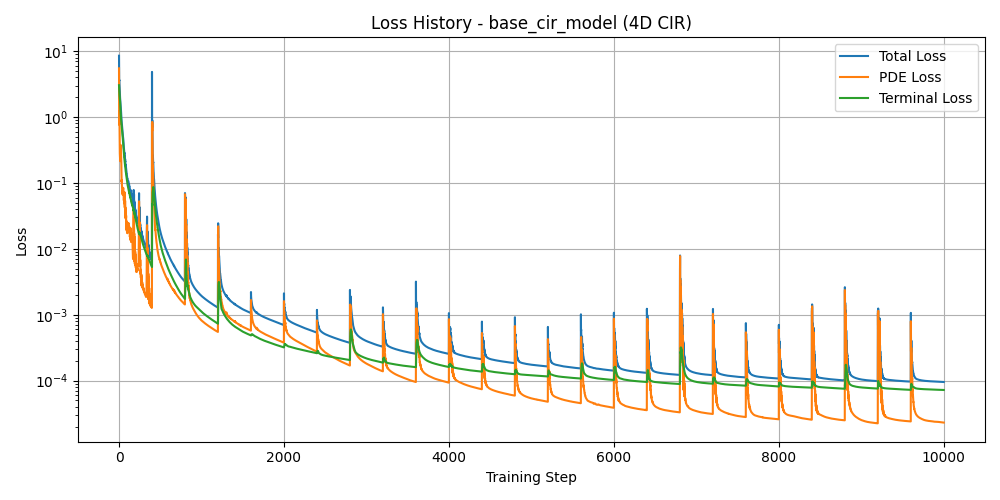

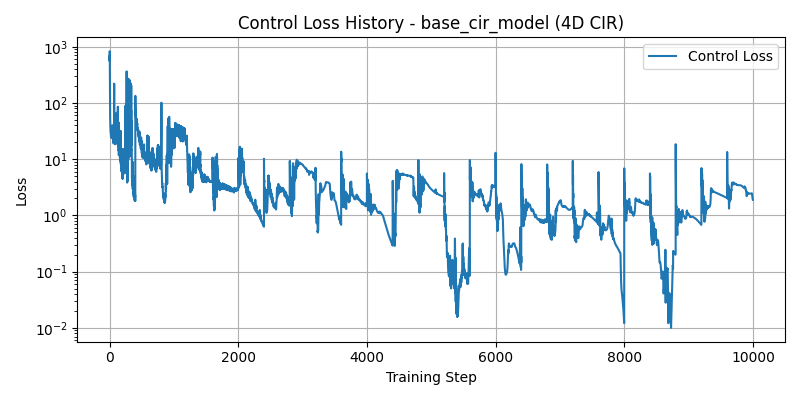

In [4]:
exp.plot_history()

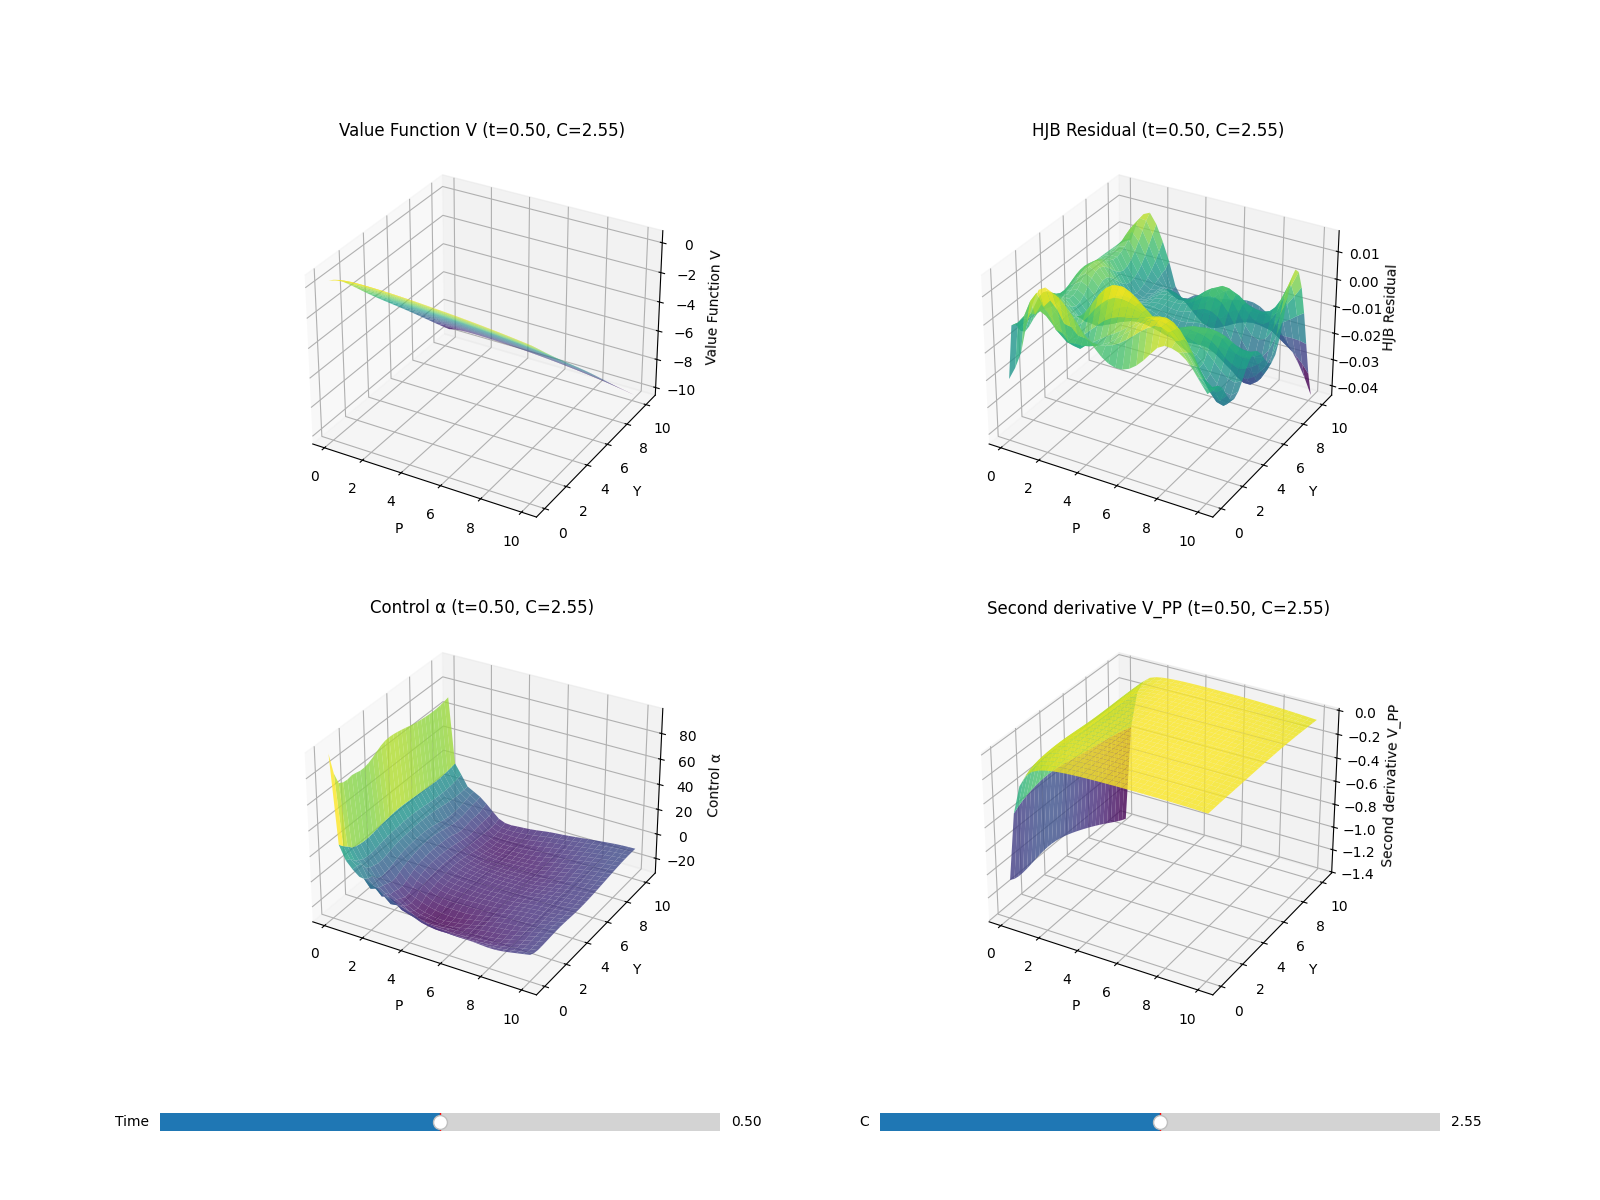

(<Figure size 1600x1200 with 6 Axes>,
 (<matplotlib.widgets.Slider at 0x7fdb09382d00>,
  <matplotlib.widgets.Slider at 0x7fdb093b94c0>))

In [5]:
exp.animate_primal_hjb_slice(P_points=30, Y_points=30, slider_dim='C')

/tmp/ipykernel_1055832/712200074.py:528: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_term = np.trapz(integrand, times)  # reward from production


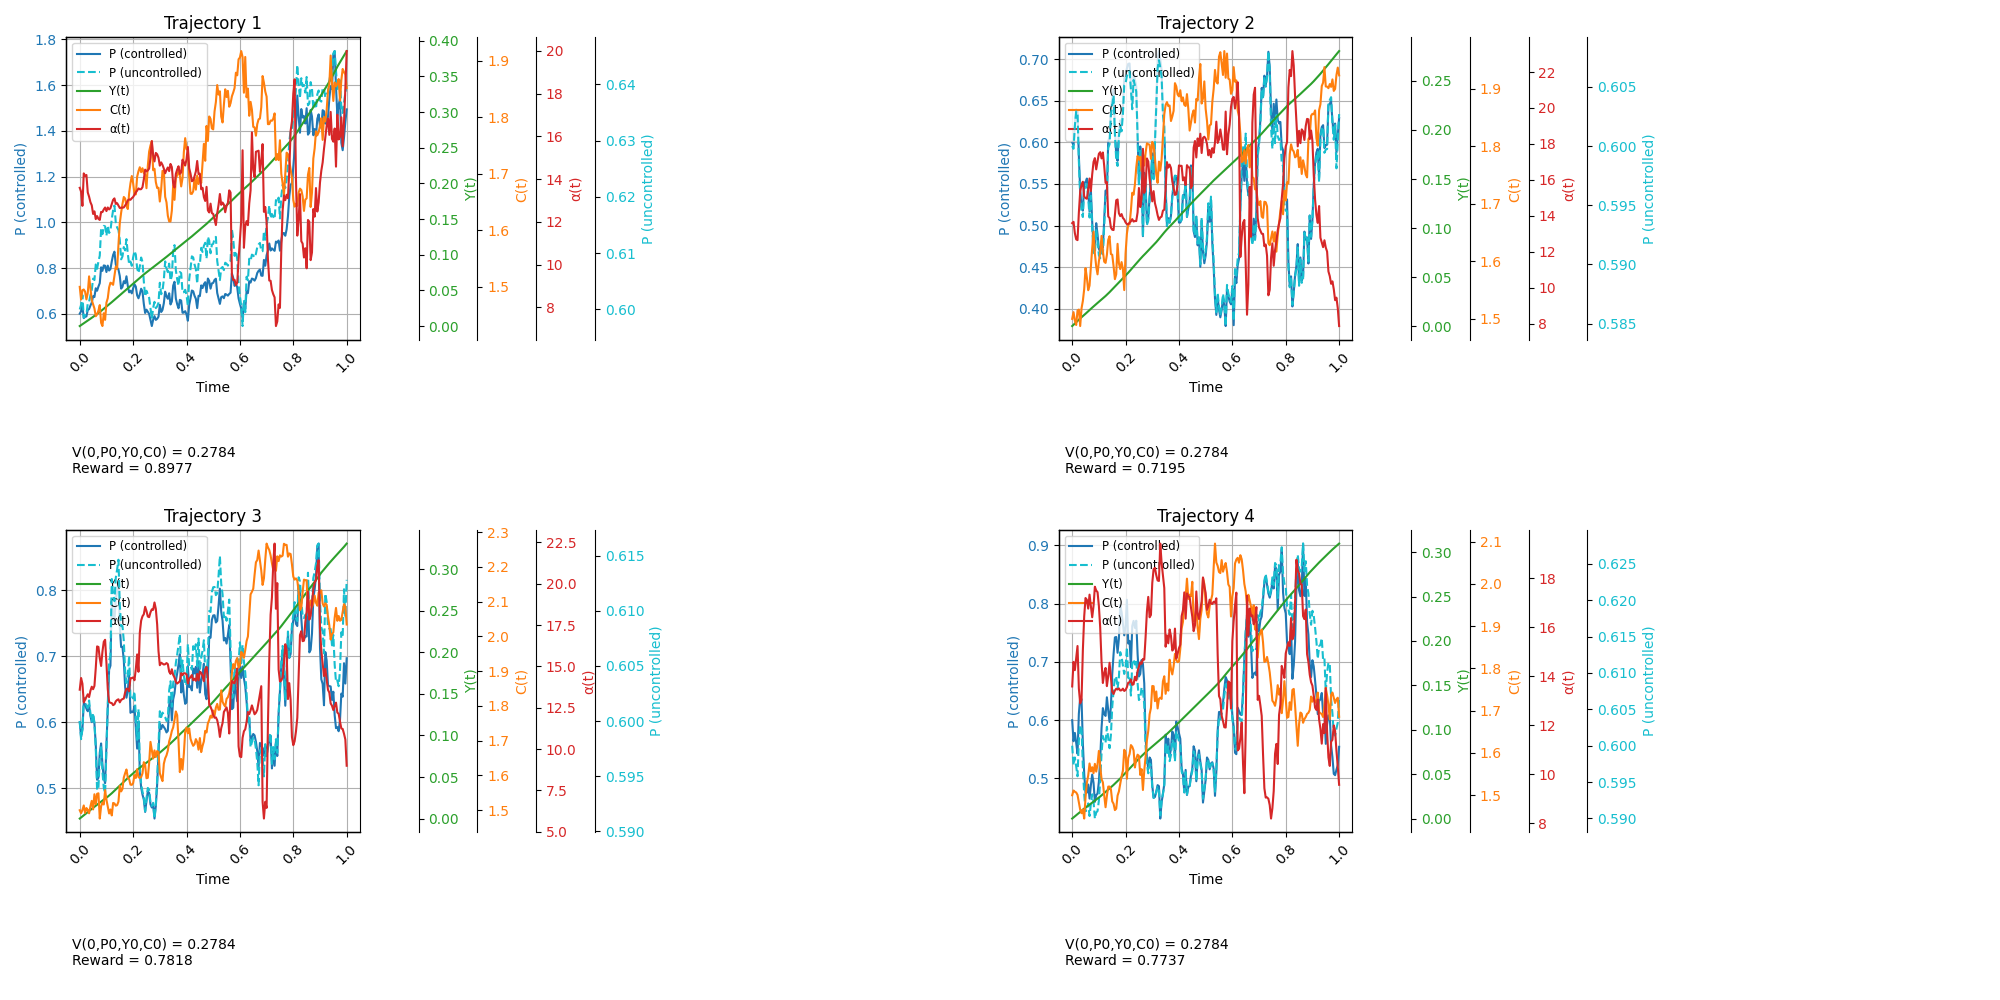

In [24]:
exp.plot_sample_trajectories(T_steps=200, N_paths=4, seed=42, P0=0.6, Y0=0, C0=1.5)

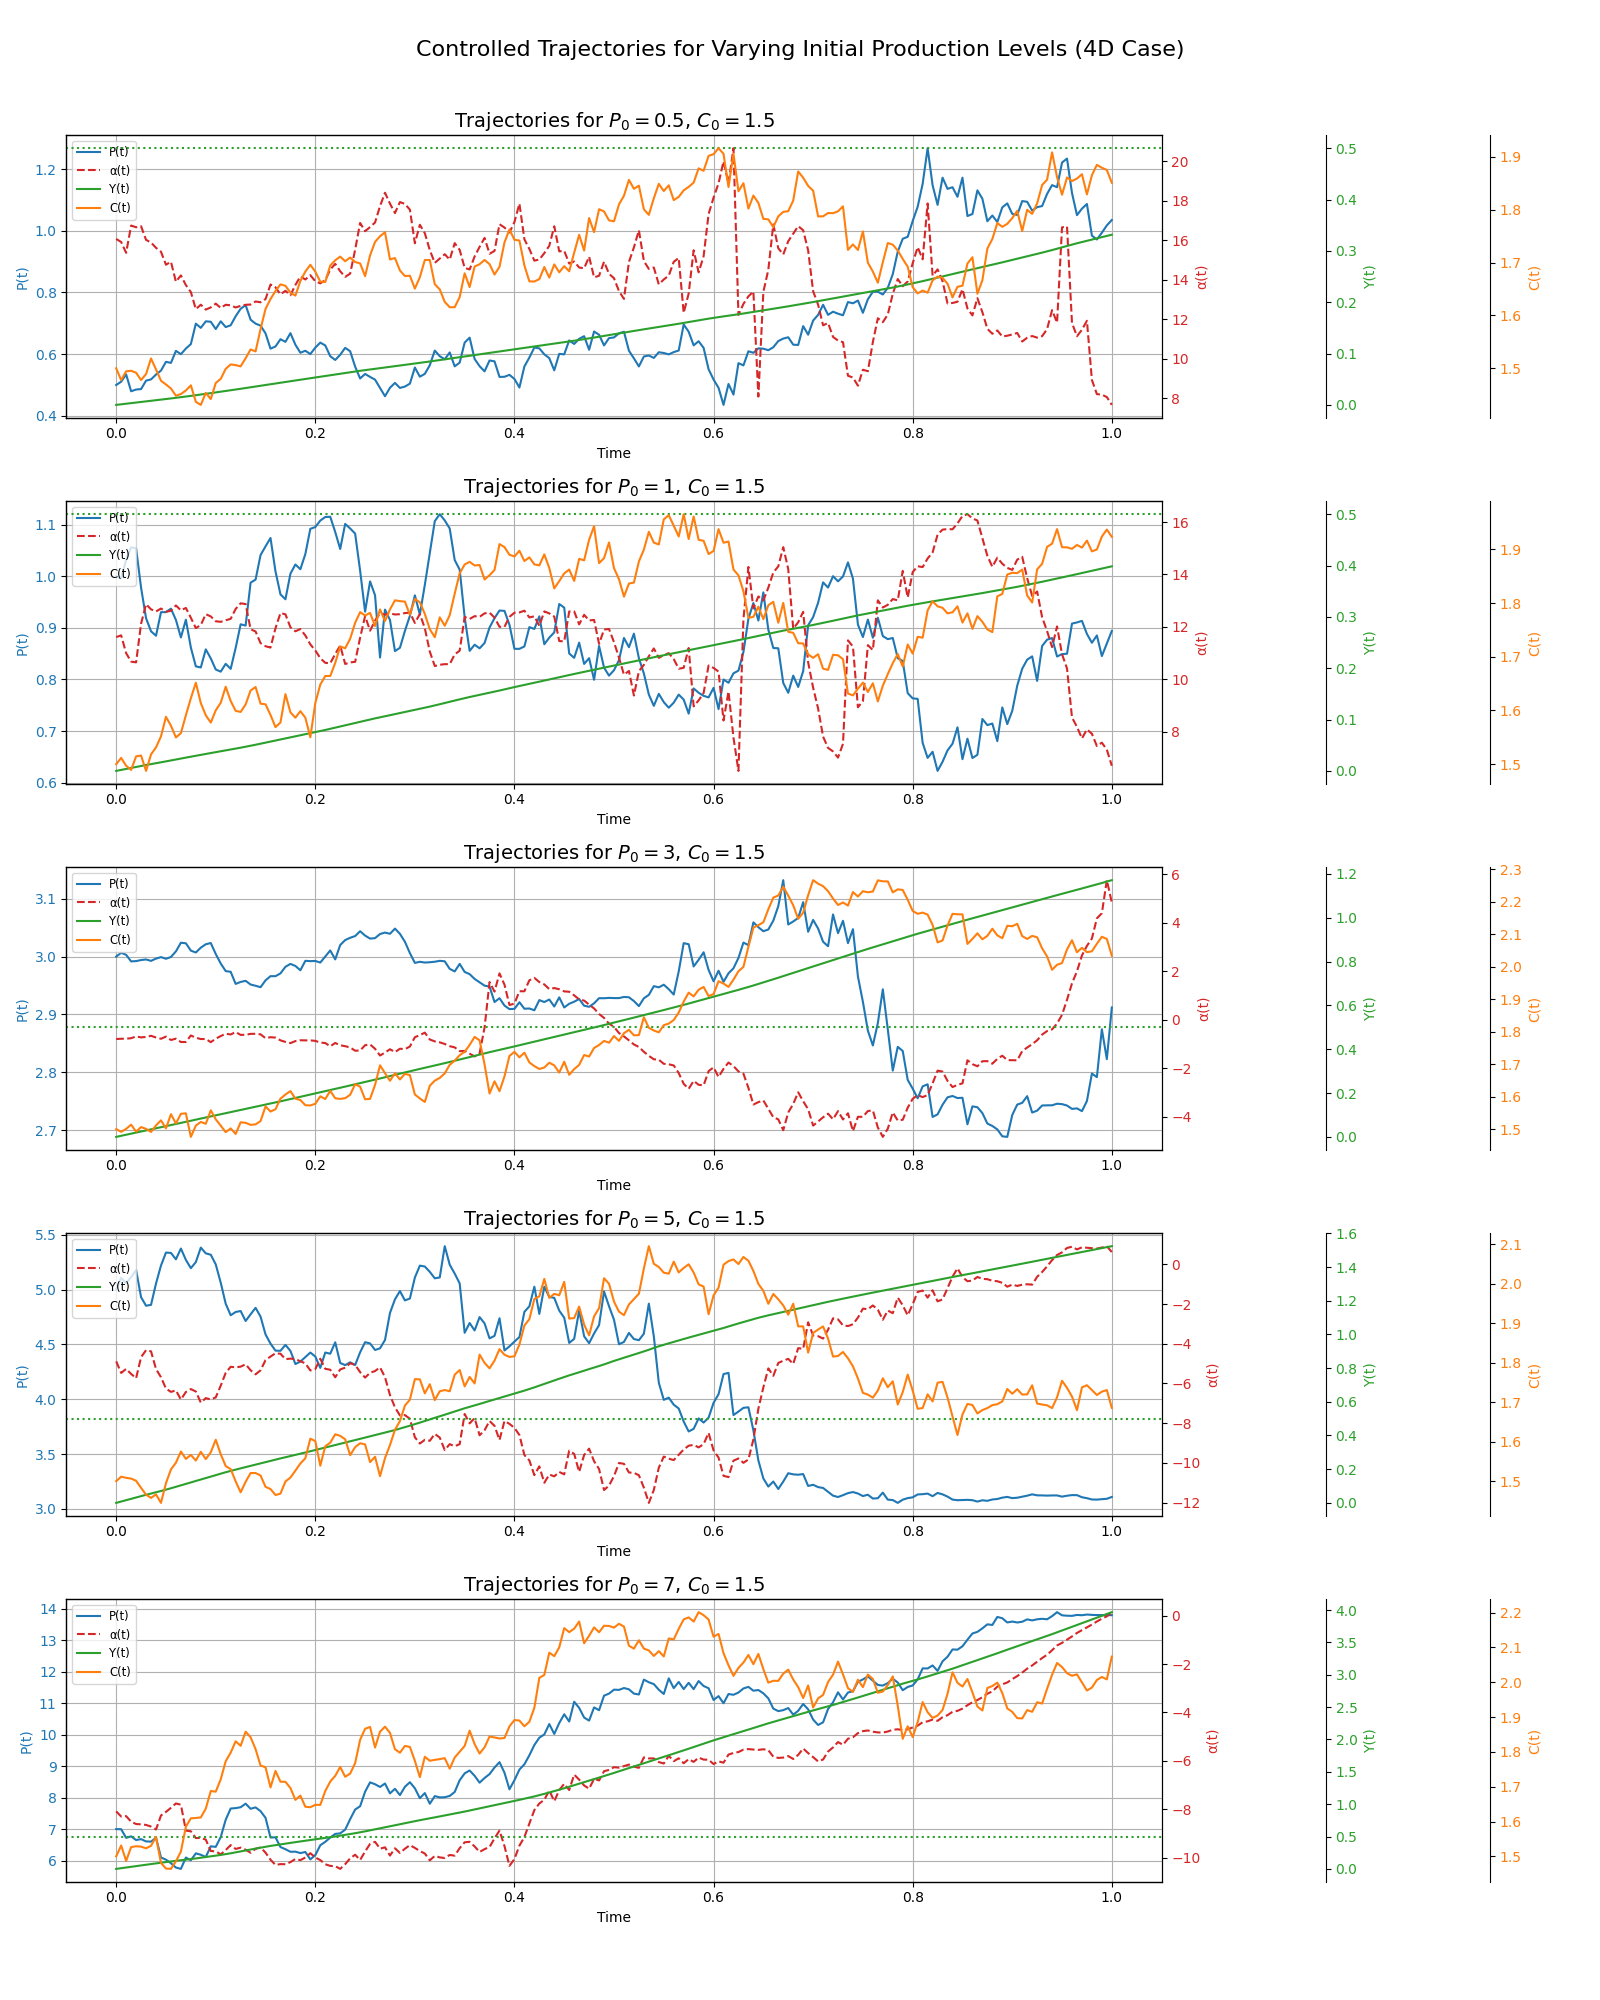

In [25]:
exp.plot_trajectories_by_initial_P([0.5, 1, 3, 5, 7], T_steps=200, seed=42)